> 🚨 **WARNING** 🚨
>
> Many cells in this notebook will not show up when viewed on GitHub. Please view the HTML version of this notebook in the [docs](https://docs.rastervision.io/en/latest/usage/tutorials/index.html).

# Reading raster data

## Reading rasters using `RasterSource`

---

We can create one from an image like shown below. `allow_streaming=True` allows us to take advantage of `rasterio`'s remote-file-reading capabilities; setting it to `False` will cause Raster Vision to download the image.

In [1]:
import os

os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [2]:
from rastervision.core.data import RasterioSource

img_uri = 's3://azavea-research-public-data/raster-vision/examples/spacenet/RGB-PanSharpen_AOI_2_Vegas_img205.tif'
raster_source = RasterioSource(img_uri, allow_streaming=True)

In [3]:
raster_source.shape

(650, 650, 3)

In [4]:
raster_source.dtype

dtype('uint16')

---

### Reading chips

`RasterSource`s support `numpy`-like array slicing, so we can read a smaller chip within the full raster like so:

In [5]:
chip = raster_source[:400, :400]
chip.shape

(400, 400, 3)

The returned chip is a `numpy` array which we can plot using `matplotlib`. Note that since the values are `uint16`, we first normalize them before plotting.

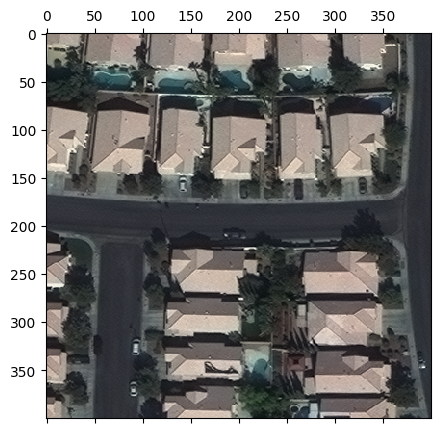

In [6]:
from matplotlib import pyplot as plt

colors_mins = chip.reshape(-1, chip.shape[-1]).min(axis=0)
colors_maxs = chip.reshape(-1, chip.shape[-1]).max(axis=0)
chip_normalized = (chip - colors_mins) / (colors_maxs - colors_mins)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(chip_normalized)
plt.show()

We can even do slightly fancier indexing. The example below reads a 400x400 chip from the the first band in the raster, subsampled to 100x100.

chip.shape: (100, 100, 1)


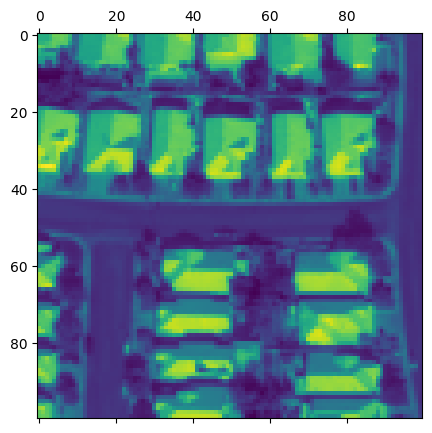

In [7]:
chip = raster_source[:400:4, :400:4, [0]]
print('chip.shape:', chip.shape)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(chip)
plt.show()

In [7]:
from rastervision.core.box import Box

chip = raster_source.get_chip(
    window=Box(ymin=0, xmin=0, ymax=400, xmax=400),
    out_shape=(100, 100),
    bands=[0])
chip.shape

(100, 100, 1)

<hr style="border:2px solid gray">

## Transforming rasters using `RasterTransformer`s

---

### `MinMaxTransformer`

In [7]:
import os

os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [16]:
from rastervision.core.data import RasterioSource, MinMaxTransformer

img_uri = 's3://azavea-research-public-data/raster-vision/examples/spacenet/RGB-PanSharpen_AOI_2_Vegas_img205.tif'
raster_source = RasterioSource(img_uri, allow_streaming=True)

raster_source_normalized = RasterioSource(
    img_uri, 
    allow_streaming=True, 
    raster_transformers=[MinMaxTransformer()])

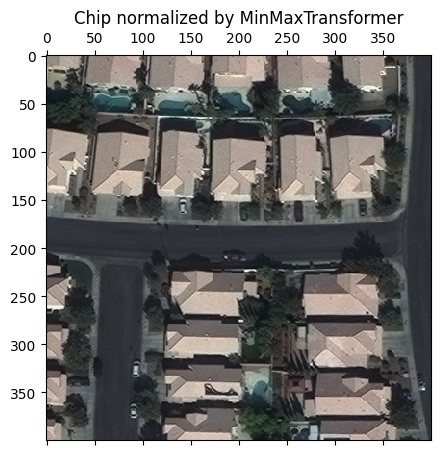

In [17]:
from matplotlib import pyplot as plt

chip = raster_source_normalized[:400, :400]

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(chip)
ax.set_title('Chip normalized by MinMaxTransformer')
plt.show()

---

### `StatsTransformer`

In [2]:
from rastervision.core import RasterStats
from rastervision.core.data import RasterioSource, StatsTransformer

img_uri = 's3://azavea-research-public-data/raster-vision/examples/spacenet/RGB-PanSharpen_AOI_2_Vegas_img205.tif'
raster_source = RasterioSource(img_uri, allow_streaming=True)

stats_transformer = StatsTransformer.from_raster_sources(
    raster_sources=[raster_source],
    max_stds=3)

raster_source_normalized = RasterioSource(
    img_uri, 
    allow_streaming=True, 
    raster_transformers=[stats_transformer])

Analyzing chips: 0it [00:00, ?it/s]

In [14]:
stats_transformer.means, stats_transformer.stds

(array([562.72325556, 716.57356667, 517.13017778]),
 array([341.09998143, 341.46870777, 197.53784742]))

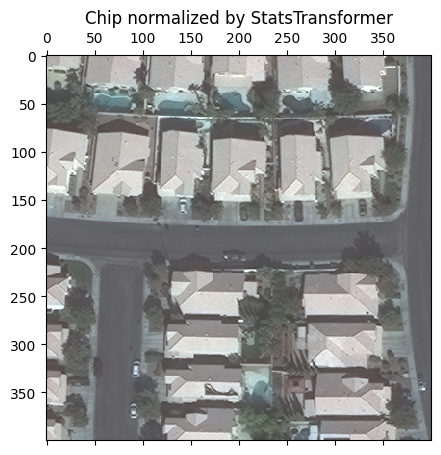

In [6]:
from matplotlib import pyplot as plt

chip_normalized = raster_source_normalized[:400, :400]

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(chip_normalized)
ax.set_title('Chip normalized by StatsTransformer')
plt.show()

To get a closer look at StatsTransformer's work, we can visualize each band's pixel intensity distributions with and without it:

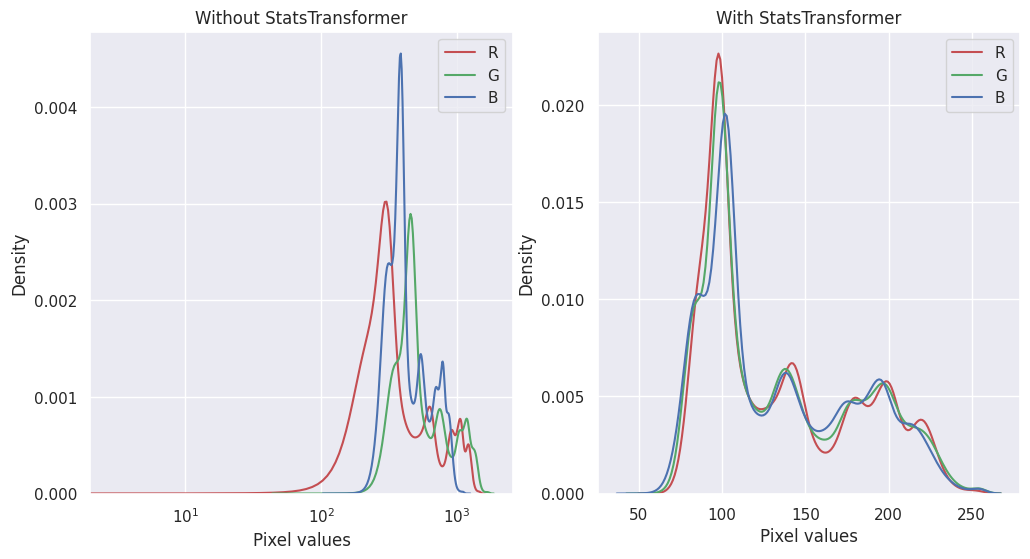

In [ ]:
import seaborn as sns
sns.reset_defaults()
sns.set_theme()

band_names = 'RGB'

raster_source_unnormalized = RasterioSource(img_uri, allow_streaming=True)
chip_unnormalized = raster_source_unnormalized[:400, :400]

fig, (ax_l, ax_r) = plt.subplots(1, 2, squeeze=True, figsize=(12, 6))

# left
for i in range(chip_unnormalized.shape[-1]):
    sns.kdeplot(chip_unnormalized[..., i].flat, ax=ax_l, c=band_names[i].lower(), label=band_names[i])
ax_l.set_xscale('log')
ax_l.set_xlabel('Pixel values')
ax_l.legend()
ax_l.set_title('Without StatsTransformer')

# right
for i in range(chip_normalized.shape[-1]):
    sns.kdeplot(
        chip_normalized[..., i].flat, ax=ax_r, c=band_names[i].lower(), label=band_names[i])
ax_r.set_xlabel('Pixel values')
ax_r.legend()
ax_r.set_title('With StatsTransformer')

plt.show()
sns.reset_defaults()

<hr style="border:2px solid gray">

## Subsetting and reordering bands

Dealing with multi-band imagery is a commonn use case in the GIS domain. All parts of Raster Vision work seamlessly with arbitrary number of bands.

The following example shows how we can use `RasterioSource` to sample 6 specific channels from a 191-band hyperspectral image.

Data from: https://engineering.purdue.edu/~biehl/MultiSpec/hyperspectral.html

In [14]:
!wget "http://cobweb.ecn.purdue.edu/~biehl/Hyperspectral_Project.zip"
!apt-get install unzip
!unzip "Hyperspectral_Project.zip"

There are 2 ways to do this. We can either instantiate a `RasterioSource` like normal and sample the subset of bands using array indexing...

In [15]:
from rastervision.core.data import RasterioSource, MinMaxTransformer

img_uri = 'Hyperspectral_Project/dc.tif'
raster_source_hsi = RasterioSource(img_uri)

raster_source_hsi.shape, raster_source_hsi.dtype

((1280, 307, 191), dtype('int16'))

In [16]:
chip = raster_source_hsi[:100, :100, [10, 30, 50, 70, 110, 130]]
chip.shape

(100, 100, 6)

... Or we can specify the `channel_order` param while instantiating the `RasterioSource`, which will automatically restrict all sampled chips to these bands.

In [17]:
raster_source_hsi = RasterioSource(
    img_uri, 
    channel_order=[10, 30, 50, 70, 110, 130],
    raster_transformers=[MinMaxTransformer()])

raster_source_hsi.shape, raster_source_hsi.dtype

((1280, 307, 6), dtype('uint8'))

In [18]:
chip = raster_source_hsi[200:500, :]
chip.shape

(300, 307, 6)

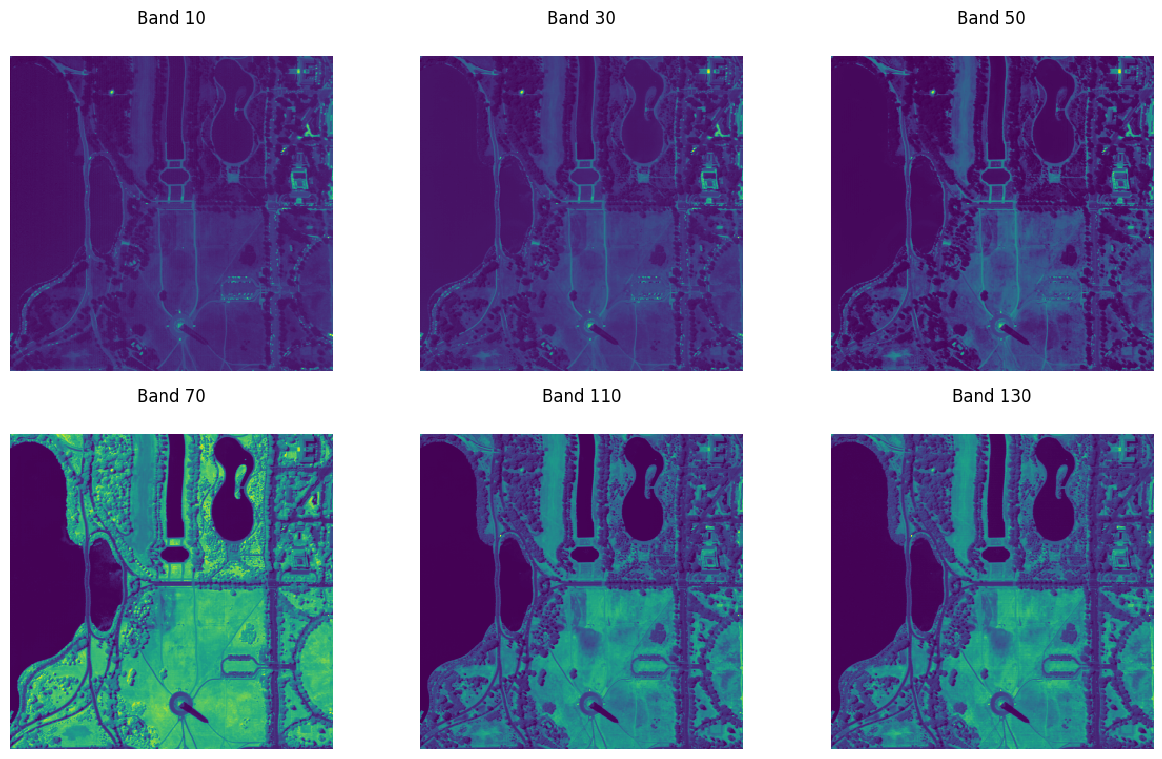

In [19]:
fig, axs = plt.subplots(2, 3, squeeze=True, figsize=(15, 9))

for i, (ax, ch) in enumerate(zip(axs.flat, raster_source_hsi.channel_order)):
    ax.matshow(chip[..., i])
    ax.set_title(f'Band {ch}')
    ax.axis('off')
plt.show()

---

## Combining bands from different files using `MultiRasterSource`

The following example combines RGB, SWIR, and SAR bands into a single 8-band ``RasterSource``.

Data from: [Cloud to Street - Microsoft flood dataset](https://mlhub.earth/data/c2smsfloods_v1)

In [21]:
uri_seninel_2_rgb = 'https://radiantearth.blob.core.windows.net/mlhub/c2smsfloods/chips/e7d1917e-c069-45cf-a392-42e24aa2f4ac/s2/S2A_MSIL1C_20201022T100051_N0209_R122_T33UXP_20201022T111023_07680-00512/RGB.png'
uri_seninel_2_swir = 'https://radiantearth.blob.core.windows.net/mlhub/c2smsfloods/chips/e7d1917e-c069-45cf-a392-42e24aa2f4ac/s2/S2A_MSIL1C_20201022T100051_N0209_R122_T33UXP_20201022T111023_07680-00512/SWIR.png'
uri_seninel_1_vh = 'https://radiantearth.blob.core.windows.net/mlhub/c2smsfloods/chips/e7d1917e-c069-45cf-a392-42e24aa2f4ac/s1/S1B_IW_GRDH_1SDV_20201020T164222_20201020T164247_023899_02D6C4_35D8_07680-00512/VH.tif'
uri_seninel_1_vv = 'https://radiantearth.blob.core.windows.net/mlhub/c2smsfloods/chips/e7d1917e-c069-45cf-a392-42e24aa2f4ac/s1/S1B_IW_GRDH_1SDV_20201020T164222_20201020T164247_023899_02D6C4_35D8_07680-00512/VV.tif'

First, we create `RasterSource`s for each individual source.

In [22]:
from rastervision.core.data import RasterioSource, MultiRasterSource, MinMaxTransformer

rs_sentinel_2_rgb = RasterioSource(uri_seninel_2_rgb, allow_streaming=True)
rs_sentinel_2_swir = RasterioSource(uri_seninel_2_swir, allow_streaming=True)

rs_seninel_1_vh = RasterioSource(uri_seninel_1_vh, allow_streaming=True, raster_transformers=[MinMaxTransformer()])
rs_seninel_1_vv = RasterioSource(uri_seninel_1_vv, allow_streaming=True, raster_transformers=[MinMaxTransformer()])

print('rs_sentinel_2_rgb', rs_sentinel_2_rgb.shape, rs_sentinel_2_rgb.dtype)
print('rs_sentinel_2_swir', rs_sentinel_2_swir.shape, rs_sentinel_2_swir.dtype)
print('rs_seninel_1_vh', rs_seninel_1_vh.shape, rs_seninel_1_vh.dtype)
print('rs_seninel_1_vv', rs_seninel_1_vv.shape, rs_seninel_1_vv.dtype)

rs_sentinel_2_rgb (512, 512, 3) uint8
rs_sentinel_2_swir (512, 512, 3) uint8
rs_seninel_1_vh (512, 512, 1) uint8
rs_seninel_1_vv (512, 512, 1) uint8


In [23]:
raster_sources = [
    rs_sentinel_2_rgb,
    rs_sentinel_2_swir,
    rs_seninel_1_vh,
    rs_seninel_1_vv
]

raster_source_multi = MultiRasterSource(
    raster_sources=raster_sources, primary_source_idx=0)

raster_source_multi.shape, raster_source_multi.dtype

((512, 512, 8), dtype('uint8'))

In [24]:
chip = raster_source_multi[:, :]
chip.shape

(512, 512, 8)

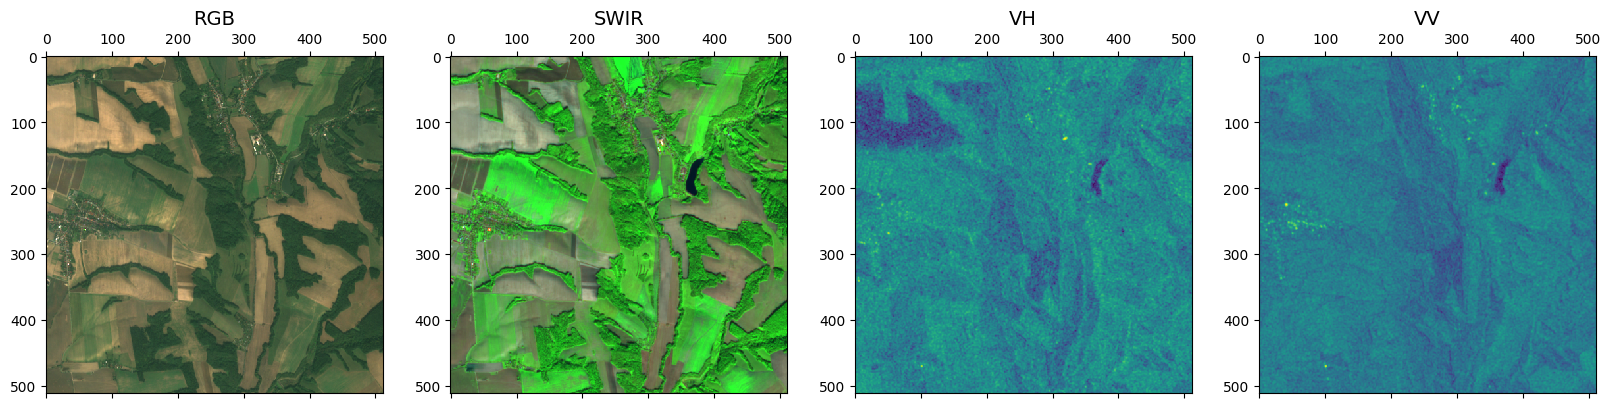

In [25]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
(ax_rgb, ax_swir, ax_vh, ax_vv) = axs.flat

ax_rgb.matshow(chip[..., :3])
ax_rgb.set_title('RGB', fontsize=14)
ax_swir.matshow(chip[..., 3:6])
ax_swir.set_title('SWIR', fontsize=14)
ax_vh.matshow(chip[..., 6])
ax_vh.set_title('VH', fontsize=14)
ax_vv.matshow(chip[..., 7])
ax_vv.set_title('VV', fontsize=14)

plt.show()

---

## Creating a time-series of images using `TemporalMultiRasterSource`

Let's pretend that `rs_seninel_1_vh` and `rs_seninel_1_vh` are images of the same area from two different times. Then we can stack them into a time-series as below.

In [3]:
from rastervision.core.data import TemporalMultiRasterSource

raster_sources = [
    rs_seninel_1_vh,
    rs_seninel_1_vv
]
raster_source_temporal = TemporalMultiRasterSource(raster_sources=raster_sources)
raster_source_temporal.shape

(2, 512, 512, 1)

**See also the notebook: _[Working with time-series of images](temporal.ipynb)_**

<hr style="border:2px solid gray">

## Cropping the extent

Sometimes you might want to crop a `RasterSource`. For example, if you want to use one part of it for training and another for validation. You can do this via the `bbox` param.

The following example shows how we can crop out the top 200 pixels and left 200 pixels of the full raster.

In [7]:
import os

os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [19]:
from rastervision.core.data import RasterioSource, MinMaxTransformer
from rastervision.core.box import Box

img_uri = 's3://azavea-research-public-data/raster-vision/examples/spacenet/RGB-PanSharpen_AOI_2_Vegas_img205.tif'
raster_source_cropped = RasterioSource(
    img_uri, 
    allow_streaming=True, 
    bbox=Box(200, 200, 650, 650),
    raster_transformers=[MinMaxTransformer()])

raster_source_cropped.shape, raster_source_cropped.dtype

((450, 450, 3), dtype('uint8'))

(400, 400, 3)


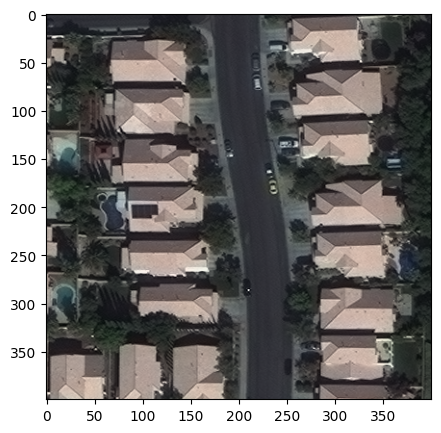

In [20]:
from rastervision.core.box import Box
from matplotlib import pyplot as plt

chip = raster_source_cropped[:400, :400]
print(chip.shape)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(chip)
plt.show()